# General Settings

Import Libraries that are used in the Reinforcement Learning algorithm

In [51]:
import torch 
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy
from itertools import count

### Hyperparameter Settings

The configuration initially follows the [supplementary information section](https://arxiv.org/pdf/1509.02971.pdf?ref=blog.paperspace.com) of the DDPG paper in page 11.

In [52]:
BUFFER_SIZE=1000000 # Buffer size of 1 million entries

BATCH_SIZE=64   # Sampling from memory - This can be 128 for more complex tasks such as Hopper
update_iteration=100

tau=0.001       # Target Network HyperParameters (soft updating)
gamma=0.99      # ?

directory = './'

# Neural Network architecture:
hidden1=20  # Neuron of 1st Layers #400 #20
hidden2=64  # Neurons of 2nd layers #300 #64

### Exploration 

To ensure **exploration**, we have to add noise to the action. An **Ornstein-Uhlenbeck** process is chosen to add noise in a smooth way, suitable for continuous control tasks.

In [53]:
import numpy as np
import random
import copy

class OU_Noise(object):
    """Ornstein-Uhlenbeck process.
    
    The OU_Noise class has four attributes
    
        size: the size of the noise vector to be generated
        mu: the mean of the noise, set to 0 by default
        theta: the rate of mean reversion, controlling how quickly the noise returns to the mean
        sigma: the volatility of the noise, controlling the magnitude of fluctuations
    """

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.25):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample.
        This method uses the current state of the noise and generates the next sample
        """
        dx = self.theta * (self.mu - self.state) + self.sigma * np.array([np.random.normal() for _ in range(len(self.state))])
        self.state += dx
        return self.state

### Replay Buffer
Implement a simple replay buffer without priority

In [54]:
class Replay_buffer():
    '''
    Code based on:
    https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    Expects tuples of (state, next_state, action, reward, done)
    '''
    def __init__(self, max_size=BUFFER_SIZE):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def push(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, BATCH_SIZE):
        """Sample a batch of experiences.
        Parameters
        ----------
        BATCH_SIZE: int
            How many transitions to sample.
        Returns
        -------
        state: np.array
            batch of state or observations
        action: np.array
            batch of actions executed given a state
        reward: np.array
            rewards received as results of executing action
        next_state: np.array
            next state next state or observations seen after executing action
        done: np.array
            done[i] = 1 if executing ation[i] resulted in
            the end of an episode and 0 otherwise.
        """
        ind = np.random.randint(0, len(self.storage), size=BATCH_SIZE)
        state, next_state, action, reward, done = [], [], [], [], []

        for i in ind:
            st, n_st, act, rew, dn = self.storage[i]
            state.append(np.array(st, copy=False))
            next_state.append(np.array(n_st, copy=False))
            action.append(np.array(act, copy=False))
            reward.append(np.array(rew, copy=False))
            done.append(np.array(dn, copy=False))

        return np.array(state), np.array(next_state), np.array(action), np.array(reward).reshape(-1, 1), np.array(done).reshape(-1, 1)


### Network Architecture

Network architecture is defined:

- **Actor** is composed of:
    - 3 FC (Fully-connected) Layers 
    - Hyperbolic tangent as the activation function -> Deals with a *-1,1* value range

- **Critic** is composed of:
    - Input: *state* & *action*
    - Output: Q-value after 3 FC Layers


In complex tasks, a *higher batch size* is required (128 instead of 64) and *batch normalisation layers* between input and hidden layers in both actor and critic.

In [55]:
class Actor(nn.Module):
    """
    The Actor model takes in a state observation as input and 
    outputs an action, which is a continuous value.
    
    It consists of four fully coonected linear layers with ReLU activation functions and 
    a final output layer selects one single optimized action for the state
    """
    def __init__(self, n_states, action_dim, hidden1):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states, hidden1), 
            nn.ReLU(), 
            nn.Linear(hidden1, hidden1), 
            nn.ReLU(), 
            nn.Linear(hidden1, hidden1), 
            nn.ReLU(), 
            nn.Linear(hidden1, 1)
        )
        
    def forward(self, state):
        return self.net(state)

class Critic(nn.Module):
    """
    The Critic model takes in both a state observation and an action as input and 
    outputs a Q-value, which estimates the expected total reward for the current state-action pair. 
    
    It consists of four linear layers with ReLU activation functions, 
    State and action inputs are concatenated before being fed into the first linear layer. 
    
    The output layer has a single output, representing the Q-value
    """
    def __init__(self, n_states, action_dim, hidden2):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states + action_dim, hidden2), 
            nn.ReLU(), 
            nn.Linear(hidden2, hidden2), 
            nn.ReLU(), 
            nn.Linear(hidden2, hidden2), 
            nn.ReLU(), 
            nn.Linear(hidden2, action_dim)
        )
        
    def forward(self, state, action):
        return self.net(torch.cat((state, action), 1))

### GPU Setup 

GPU is used for faster training if your machine has one 

In [56]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


### DDPG Agent

Creates a replay buffer, an actor-critic network and their corresponding target networks. Additionally, it also initializes the optimizer for both networks.

In [57]:
class DDPG(object):
    def __init__(self, state_dim, action_dim):
        """
        Initializes the DDPG agent. 
        Takes three arguments:
               state_dim which is the dimensionality of the state space, 
               action_dim which is the dimensionality of the action space, and 
               max_action which is the maximum value an action can take. 
        
        Creates a replay buffer, an actor-critic  networks and their corresponding target networks. 
        It also initializes the optimizer for both actor and critic networks alog with 
        counters to track the number of training iterations.
        """
        self.replay_buffer = Replay_buffer()
        
        self.actor = Actor(state_dim, action_dim, hidden1).to(device)
        self.actor_target = Actor(state_dim, action_dim,  hidden1).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-3)

        self.critic = Critic(state_dim, action_dim,  hidden2).to(device)
        self.critic_target = Critic(state_dim, action_dim,  hidden2).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=2e-2)
        # learning rate

        

        self.num_critic_update_iteration = 0
        self.num_actor_update_iteration = 0
        self.num_training = 0


    def select_action(self, state):
        """
        takes the current state as input and returns an action to take in that state. 
        It uses the actor network to map the state to an action.
        """
        
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def update(self):
        """
        updates the actor and critic networks using a batch of samples from the replay buffer. 
        For each sample in the batch, it computes the target Q value using the target critic network and the target actor network. 
        It then computes the current Q value 
        using the critic network and the action taken by the actor network. 
        
        It computes the critic loss as the mean squared error between the target Q value and the current Q value, and 
        updates the critic network using gradient descent. 
        
        It then computes the actor loss as the negative mean Q value using the critic network and the actor network, and 
        updates the actor network using gradient ascent. 
        
        Finally, it updates the target networks using 
        soft updates, where a small fraction of the actor and critic network weights are transferred to their target counterparts. 
        This process is repeated for a fixed number of iterations.
        """

        for it in range(update_iteration):
            # For each Sample in replay buffer batch
            state, next_state, action, reward, done = self.replay_buffer.sample(BATCH_SIZE)
            state = torch.FloatTensor(state).to(device)
            print(state)
            action = torch.FloatTensor(action).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(1-done).to(device)
            reward = torch.FloatTensor(reward).to(device)

            # Compute the target Q value
            target_Q = self.critic_target(next_state, self.actor_target(next_state))
            target_Q = reward + (done * gamma * target_Q).detach()

            # Get current Q estimate
            current_Q = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q, target_Q)
            
            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss as the negative mean Q value using the critic network and the actor network
            actor_loss = -self.critic(state, self.actor(state)).mean()
            

            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            
            """
            Update the frozen target models using 
            soft updates, where 
            tau,a small fraction of the actor and critic network weights are transferred to their target counterparts. 
            """
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
            
           
            self.num_actor_update_iteration += 1
            self.num_critic_update_iteration += 1
    def save(self):
        """
        Saves the state dictionaries of the actor and critic networks to files
        """
        torch.save(self.actor.state_dict(), directory + 'actor.pth')
        torch.save(self.critic.state_dict(), directory + 'critic.pth')
        

    def load(self):
        """
        Loads the state dictionaries of the actor and critic networks to files
        """
        self.actor.load_state_dict(torch.load(directory + 'actor.pth'))
        self.critic.load_state_dict(torch.load(directory + 'critic.pth'))
       


### Initialize a DDPG Instance

Call the environment to be trained. Always use the same seed for data reproducibility

In [58]:
import gym

# Example environment:
# create the environment
env_name='MountainCarContinuous-v0'
env = gym.make(env_name)

# new environment
# new_env = gym.make()

# XX
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define different parameters for training the agent:
    # Episodes:
MAX_EPISODE=10          # Number of episodes 200
ep_r = -np.inf          # Initial episode reward: normally 0 or -infinity
score_hist=[]           # Initialize the list where all historical rewards of each episode are stored
    # Steps:
MAX_TIME_STEPS=50       # Number of steps taken per episode before moving on # 5000
total_step = 0          # Initialize step count in each episode: [0, MAX_TIME_STEPS]




# # To render the environmnet:
# render=True
# render_interval=10

# For Reproducibility:
# env.seed(0)
torch.manual_seed(-1)
np.random.seed(0)

# Environment action and states
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
min_Val = torch.tensor(1e-7).float().to(device) 


# Exploration Noise
exploration_noise=0.1
exploration_noise=0.1 * max_action

### Iterate Through Episodes

In [59]:
# Create a DDPG instance
agent = DDPG(state_dim, action_dim)
print("State dim: {}, Action dim: {}".format(state_dim, action_dim))

# Train the agent for the number of episodes set:
for i in range(MAX_EPISODE):
    total_reward = 0
    step =0
    state = env.reset()
    # print(state)
    # state=state[0]
    # print(state)
    for  t in range(MAX_TIME_STEPS):
        action = agent.select_action(state)
        # Add Gaussian noise to actions for exploration
        action = (action + np.random.normal(0, 1, size=action_dim)).clip(-max_action, max_action)
        # print(env.step(action))
        # action += OU_Noise.sample(action)
        next_state = env.step(action)[0]
        reward, done, info = env.step(action)[1:]

        total_reward += reward
        # if render and i >= render_interval : env.render()
        agent.replay_buffer.push((state, next_state, action, reward, float(done)))
        state = next_state
        # print(state)
        if done:
            break
        step += 1
        
    score_hist.append(total_reward)
    total_step += step+1
    print("Episode: \t{}  Total Reward: \t{:0.2f}".format( i, total_reward))
    agent.update()
    if i % 100 == 0:
        agent.save()
env.close()

State dim: 2, Action dim: 1
Episode: 	0  Total Reward: 	-2.86
tensor([[-0.4995, -0.0068],
        [-0.4255, -0.0031],
        [-0.4138, -0.0030],
        [-0.4659, -0.0078],
        [-0.5251, -0.0060],
        [-0.5358, -0.0060],
        [-0.3862,  0.0039],
        [-0.4892,  0.0050],
        [-0.5503,  0.0007],
        [-0.4042,  0.0000],
        [-0.5735,  0.0021],
        [-0.3862,  0.0039],
        [-0.5769, -0.0006],
        [-0.4042,  0.0000],
        [-0.5358, -0.0060],
        [-0.5485,  0.0012],
        [-0.5517,  0.0021],
        [-0.5251, -0.0060],
        [-0.5738, -0.0044],
        [-0.3984,  0.0017],
        [-0.5517,  0.0021],
        [-0.4842,  0.0016],
        [-0.4138, -0.0030],
        [-0.5251, -0.0060],
        [-0.5154,  0.0079],
        [-0.4659, -0.0078],
        [-0.3833, -0.0024],
        [-0.4042,  0.0000],
        [-0.3903, -0.0036],
        [-0.4863, -0.0020],
        [-0.4995, -0.0068],
        [-0.4012,  0.0012],
        [-0.5517,  0.0021],
        [-0.55

tensor([[-5.5025e-01,  6.7141e-04],
        [-3.9834e-01, -4.2773e-03],
        [-5.6652e-01,  4.0256e-03],
        [-5.3150e-01,  6.7098e-03],
        [-5.7346e-01,  2.1210e-03],
        [-4.8465e-01, -8.9525e-03],
        [-5.5029e-01, -7.0301e-03],
        [-4.6593e-01, -7.8425e-03],
        [-5.5716e-01,  4.2478e-03],
        [-4.9260e-01, -2.5030e-03],
        [-4.8921e-01,  5.0315e-03],
        [-4.8635e-01, -1.9734e-03],
        [-5.5025e-01,  6.7141e-04],
        [-4.8921e-01,  5.0315e-03],
        [-4.9952e-01, -6.8037e-03],
        [-5.0087e-01,  7.0560e-03],
        [-4.9952e-01, -6.8037e-03],
        [-3.7940e-01, -3.8675e-04],
        [-4.8921e-01,  5.0315e-03],
        [-4.9586e-01, -2.0261e-03],
        [-5.1189e-01, -5.7020e-03],
        [-4.2553e-01, -3.1391e-03],
        [-5.4854e-01,  1.1647e-03],
        [-4.0357e-01,  6.2346e-04],
        [-5.7689e-01, -5.8813e-04],
        [-5.4331e-01,  3.4525e-03],
        [-4.8420e-01,  1.6150e-03],
        [-4.0419e-01,  0.000

In [60]:
import matplotlib.pyplot as plt 
import numpy as np
def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    #plt.savefig(figure_file)

#### Plot Reward History Average

Over all the episodes, the reward history average is plotted per episode

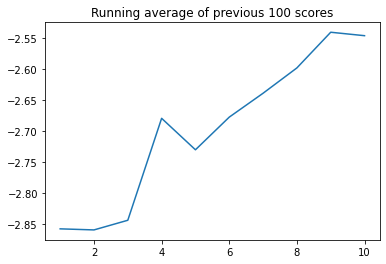

In [61]:
x = [i+1 for i in range(len(score_hist))]
plot_learning_curve(x, score_hist)

In [62]:
test_iteration=10              # 100
max_length_of_trajectory=100   # 1000 
for i in range(test_iteration):
    state = env.reset()
    for t in count():
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(np.float32(action))
        ep_r += reward
        print(reward)
        
        # env.render()
        if done: 
            # print("reward{}".format(reward))
            print("Episode \t{}, the episode reward is \t{:0.2f}".format(i, ep_r))
            ep_r = 0
            # env.render()
            break
        state = next_state
env.close()   

-3.299852175560197e-05
-3.2629341576274896e-05
-3.207360729606951e-05
-3.1340321576195375e-05
-3.0441283595362968e-05
-2.9390837497178526e-05
-2.820546964769216e-05
-2.69034604515106e-05
-2.5504408498301657e-05
-2.402892294371068e-05
-2.249807119778036e-05
-2.0932906838869258e-05
-1.9354023912426887e-05
-1.7781233392511702e-05
-1.6232986344642907e-05
-1.4726274490052625e-05
-1.3281631876117893e-05
-1.1999544257266464e-05
-1.0787345354199094e-05
-9.652710363745964e-06
-8.601418143177557e-06
-7.637193108710974e-06
-6.761880087420656e-06
-5.9756250525956105e-06
-5.276976043765234e-06
-4.663297793405189e-06
-4.130855923436486e-06
-3.6751841958727365e-06
-3.2913854571201864e-06
-2.9744176621723278e-06
-2.7193712978505237e-06
-2.5216831875640202e-06
-2.3774757195075585e-06
-2.2836355951801924e-06
-2.2380073688163005e-06
-2.239502086682447e-06
-2.288177410593537e-06
-2.3851399464023573e-06
-2.5325974423875446e-06
-2.7336840940605547e-06
-2.9923439301666504e-06
-3.3130839768206504e-06
-3.70083